# Real-time risk with atoti

# Imports

In [1]:
import QuantLib as ql 
import time
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import numpy as np
import random
from collections import namedtuple

## atoti session

In [2]:
import atoti as tt
import pandas as pd
from atoti.config import create_config

config = create_config(metadata_db="./metadata.db", max_memory = "8G", sampling_mode=tt.sampling.FULL)
session = tt.create_session(config=config)

Welcome to atoti 0.4.2.20200617181308!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


# atoti cube

In [3]:
sensitivities_store = session.read_csv(
    "risk_data.csv",
    keys=["AsOfDate","TradeId", "RiskFactor"],
    store_name="Sensitivities",
    types = {"TradeId": tt.types.STRING, "AsOfDate": tt.types.LOCAL_DATE},
    watch=True # this will make the data store watch for file updates and fetch new data
)

In [4]:
sensitivities_store.head(3)

MarketValue        Delta
AsOfDate   TradeId RiskFactor                          
2020-07-01 0       OXY            9.953595   218.150880
           1       AAPL         200.165575 -4469.315240
           2       AAPL         192.338869  4854.344159

In [5]:
market_data_store = session.read_pandas(
    pd.DataFrame(columns=["AsOfDate", "Instrument", "Quote"]),
    keys=["AsOfDate", "Instrument"],
    store_name="Market Data Store",
    types = {"AsOfDate": tt.types.LOCAL_DATE, "Instrument": tt.types.STRING, "Quote": tt.types.DOUBLE}
)

In [6]:
# example
market_data_store.append(("2020-05-01", "AAPL", 310.0))

In [7]:
market_data_store.head(3)

,,Quote
AsOfDate,Instrument,
2020-05-01,AAPL,310.0


In [8]:
# This join will link sensitivities store and market data store and allow displaying sensitivities next to quotes.
sensitivities_store.join(market_data_store, mapping={"AsOfDate": "AsOfDate", "RiskFactor": "Instrument"})

cube = session.create_cube(
    sensitivities_store, "Sensitivities")  
m = cube.measures

# Hiding automatically created measures for mean
m['MarketValue.MEAN'].visible = False 
m['Delta.MEAN'].visible = False

In [9]:
lvl = cube.levels
h = cube.hierarchies
h['AsOfDate'].slicing = True
h

Hierarchies()

In [11]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

In [11]:
lvl["AsOfDate"].comparator = tt.comparator.DESC

In [12]:
session.url

'http://localhost:61767'

# Fetching market data

I'm fetching stock prices data which I will stream later in this notebook to emulate a real-time data source.

In [23]:
datetime.datetime.today().timestamp()

1594078449.000074

In [29]:
import requests
import pandas as pd
import arrow
import datetime
import os
from functools import reduce

tickers = "OXY MSFT AAPL"
today = datetime.datetime.strptime("2020-07-06", "%Y-%m-%d")

# setting up a period
dt2 = today + timedelta(days=5)
p2 = int(dt2.timestamp())


def get_quote_data(
    symbol="AAPL", period1=int(today.timestamp()), period2=p2, data_interval="1m"
):
    # This function is fetching historical intraday spot prices from yfinance
    res = requests.get(
        "https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?&period1={period1}&period2={period2}&interval={data_interval}".format(
            **locals()
        )
    )
    data = res.json()
    body = data["chart"]["result"][0]
    dt = pd.Series(
        map(lambda x: arrow.get(x).datetime.replace(tzinfo=None), body["timestamp"]),
        name="Datetime",
    )
    df = pd.DataFrame(body["indicators"]["quote"][0], index=dt)
    df = df.loc[:, ("close")]
    return df




In [30]:
dfs = [get_quote_data(inst) for inst in tickers.split()]
historic_spot_prices = reduce(
    lambda left, right: pd.merge(left, right, how="outer", on="Datetime"), dfs
)
historic_spot_prices.columns = tickers.split()
historic_spot_prices.head(10)

,OXY,MSFT,AAPL
Datetime,,,
2020-07-06 13:30:00,18.070000,208.860001,370.459991
2020-07-06 13:31:00,18.090000,208.559998,371.197510
2020-07-06 13:32:00,18.059999,208.904999,371.470001
2020-07-06 13:33:00,17.959999,208.575104,371.190002
2020-07-06 13:34:00,17.910000,208.679993,371.410004
2020-07-06 13:35:00,17.864799,209.244995,371.779999
2020-07-06 13:36:00,17.910000,208.956100,371.890015
2020-07-06 13:37:00,17.915001,208.899994,371.720001
2020-07-06 13:38:00,17.990000,208.979996,371.100098


# Trades

I'm generating a portfolio that I will be repricing when prices change.

In [31]:
Trade = namedtuple('Trade', 'TradeId Ticker Book Product Quantity Strike Maturity OptionType')
def generate_positions(num):
    positions = []
    for i in range(num):
        t = random.choice(tickers.split())
        p = Trade(TradeId = i,
                  Ticker = t, 
                  Book = random.choice(["EQ_VOL_HED", "EQ_STRUCT", "EQ_LARG_DM", "EQ_WAREHOU", "EQ_SMAL_EM"]),
                  Product = "EQ_Option",
                  Quantity = random.choice([100,-100,50,-50]), 
                  Strike = random.choice(historic_spot_prices[t].dropna()), 
                  Maturity = today + timedelta(days = random.randint(0, 365*20)), 
                  OptionType = random.choice(['call', 'put']))
        positions.append(p)
    return positions

positions = generate_positions(20)
positions[:3]

[Trade(TradeId=0, Ticker='AAPL', Book='EQ_VOL_HED', Product='EQ_Option', Quantity=50, Strike=373.1099853515625, Maturity=datetime.datetime(2036, 2, 19, 0, 0), OptionType='put'),
 Trade(TradeId=1, Ticker='AAPL', Book='EQ_SMAL_EM', Product='EQ_Option', Quantity=-100, Strike=374.71978759765625, Maturity=datetime.datetime(2025, 12, 26, 0, 0), OptionType='put'),
 Trade(TradeId=2, Ticker='OXY', Book='EQ_STRUCT', Product='EQ_Option', Quantity=-50, Strike=18.100000381469727, Maturity=datetime.datetime(2032, 11, 6, 0, 0), OptionType='put')]

# Enriching risk data - Trade Attributes and Portfolio Structure

In [32]:
trade_attributes = session.read_pandas(
    pd.DataFrame(positions),
    types={"TradeId": tt.types.STRING, "Strike": tt.types.STRING},
    keys=["TradeId"],
    store_name="Trade Attributes",
)

In [33]:
book_hierarchy = session.read_pandas(
    pd.DataFrame(
        data={
            "Book": [
                "EQ_VOL_HED",
                "EQ_STRUCT",
                "EQ_LARG_DM",
                "EQ_WAREHOU",
                "EQ_SMAL_EM",
            ],
            "Desk": [
                "Structuring",
                "Structuring",
                "Equity Trading",
                "Equity Trading",
                "Equity Trading",
            ],
            "Business Unit": [
                "Equities",
                "Equities",
                "Equities",
                "Equities",
                "Equities",
            ],
        }
    ),
    keys=["Book"],
    store_name="Book Hierarchy"
)



In [34]:
sensitivities_store.join(trade_attributes)
trade_attributes.join(book_hierarchy)

h["Portfolio Structure"] = {
    "Business Unit": lvl["Business Unit"],
    "Desk": lvl['Desk'],
    "Book": lvl['Book']
}

In [36]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Cube schema

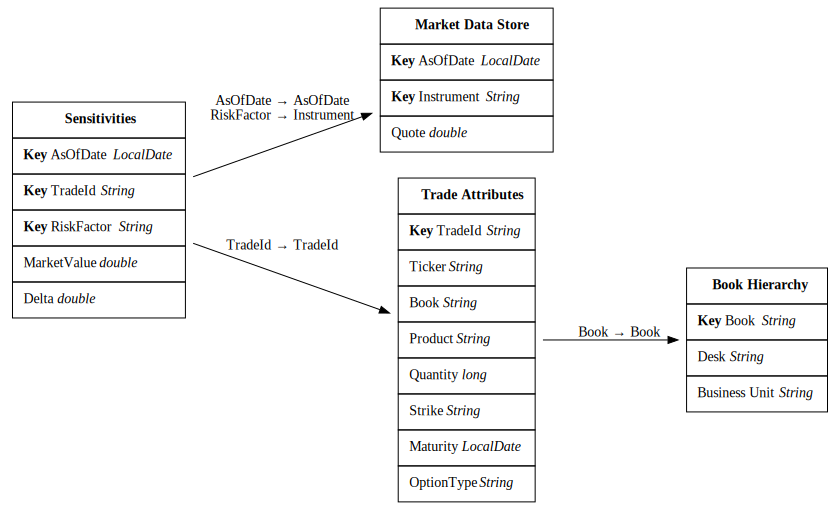

In [37]:
cube.schema

# Pricing

I'm defining functions to mockup an pricing engine. I'm using QuantLib implementation of the Black-Scholes formulae. 

In [38]:
def reprice_trade(spot_price, trade, calc_date):
    # This function takes option trade object and spot prices and computes valuation and risk metrics.
    # Volatility and interest rates are set to some constants for simplicity.
    
    calculation_date = ql.Date(calc_date.day, calc_date.month, calc_date.year)
    ql.Settings.instance().evaluationDate = calculation_date
        
    # conventions
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()
    volatility = 0.3
    dividend_rate = 0.0163
    risk_free_rate = 0.001

    maturity = getattr(trade, "Maturity")
    
    maturity_date = ql.Date(
        maturity.day, maturity.month, maturity.year
    )
    option_type = ql.Option.Call if trade.OptionType == "Call" else ql.Option.Put
    strike_price = trade.Strike

    # construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # The Black-Scholes-Merto process is constructed here.
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
    )
    bsm_process = ql.BlackScholesMertonProcess(
        spot_handle, dividend_yield, flat_ts, flat_vol_ts
    )

    european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))

    return {
        "AsOfDate": calc_date.strftime("%Y-%m-%d"),
        "TradeId": getattr(trade, "TradeId"),
        "RiskFactor": getattr(trade, "Ticker"),
        "MarketValue": european_option.NPV(),
        "Delta": european_option.delta() * spot_price * getattr(trade, "Quantity"),
    }

def reprice_portfolio(market_data, positions, calc_date):
    # This function reprices trades and greeks if market data is available,
    # and returns new risk numbers as a dataframe
    risk = []
    for trade in positions:
        spot_price_update = market_data[getattr(trade, "Ticker")]
        if not np.isnan(spot_price_update):
            risk = risk + [reprice_trade(spot_price_update, trade, calc_date)]
    return pd.DataFrame(data = risk)


# Loading T-1 risk data 

In [39]:
md = historic_spot_prices.head(1).to_dict(orient = "records")[0]
calc_date = today + timedelta(days = -1)
reprice_portfolio(md, positions, calc_date).to_csv("risk_data.csv", index = False)

In [40]:
for i in list(md.items()):
    if not np.isnan(i[1]):
        print((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))
        market_data_store.append((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))

('2020-07-05', 'OXY', 18.06999969482422)
('2020-07-05', 'MSFT', 208.86000061035156)
('2020-07-05', 'AAPL', 370.4599914550781)


In [41]:
market_data_store.head(5)

Quote
AsOfDate   Instrument            
2020-05-01 AAPL        310.000000
2020-07-05 OXY          18.070000
           MSFT        208.860001
           AAPL        370.459991

# Start real-time sources

I think section I'm emulating a market data feed, which is triggering portfolio repricing.

In [ ]:
import threading, queue
spot_update_queue = queue.Queue()

def start_spot_publisher():
    current_time = -1
    for idx, row in historic_spot_prices.iterrows():
        next_time = idx
        if current_time != -1:
            dt = (next_time - current_time).total_seconds() / 100.0
            time.sleep(dt)
        current_time = idx
        spot_update_queue.put((idx,row.to_dict()))
    spot_update_queue.join()
    print('All work completed')

    
def start_spot_update_listener():
    while True:
        calc_date, spot_prices_by_ticker = spot_update_queue.get()

        
        # Saving risk numbers into a file.
        # The sensitivities data store will "watch" the file and fetch updates.
        reprice_portfolio(spot_prices_by_ticker, positions, calc_date).to_csv("risk_data.csv", index = False)
        
        # Example of injecting the data directly into a datastore.
        # New stock prices are appended to the market data store.
        for i in list(spot_prices_by_ticker.items()):
            if not np.isnan(i[1]):
                print((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))
                market_data_store.append((calc_date.strftime("%Y-%m-%d"), i[0], i[1]))

        spot_update_queue.task_done()

threading.Thread(target=start_spot_update_listener, daemon=True).start()
start_spot_publisher()